# <center> **CS 565, Spring 2022, Homework 5**
### <center> Due **Tues March 29, 11:59 pm ET (Boston time)**, via Gradescope




### **Submission guidelines** 
Please write your solutions inside of this .ipynb file, then convert it to a PDF before submitting on Gradescope:

*   **In Jupyter:** File > Download as > PDF
*   **In Google Colab:** File > Print > Destination > Save as PDF

When you submit, please **be sure to match the answers on your PDF to the outline on Gradescope.** In other words, if the answer to problem 2.1 is on pages 2 and 3 of your PDF, please be sure to select those pages as the answer to problem 2.1 on Gradescope. Since it takes significantly longer to grade homework that is not properly matched, **we may deduct points** for noncompliant submissions.

Andrew (the TF) will cover how to get started with the notebooks for writing problem solutions and running experiments. 

<div style="page-break-after: always;"></div>

## 1. Graph component (40 points) 


Consider an undirected, unweighted graph $G=(V,E)$. 
For any subset of nodes $X\subseteq V$ we define the graph \emph{induced} by $X$,
denoted by $G[X]=\left(X,E[X]\right)$, to be the graph that has nodes $X$ and edges
$E[X]$ the subset of edges in $E$ that have \emph{both} their endpoints in $X$.
Also given a graph $G(V,E)$ and a node $v\in V$ we use $\text{degree}(v,G)$ to denote
the degree of $v$ in $G$.

Given the above definitions consider the following problem:

**max-minimum degree component**: Given $G=(V,E)$ find
$S\subseteq V$ such that 

$$
\min_{v\in S}\text{degree}(v,G[S]),
$$
is maximized.


## 1.1  (20 points) 

Design a polynomial-time algorithm for solving the above problem \emph{optimally}
Compute the running time of your algorithm. 


**Algorithm :**

1. Let $S$ be the subset of vertices, initialized as $V$.
2. Let $H_S$ be the subgraph induced by vertices $S$.
3. For each iteration, eliminate the vertex with lowest degree in $H_S$ from $S$ and recompute it's minimum degree.
4. Return the subgraph $H_S$ with the maximum of the minimum degrees computed.

**Running Time :**

This algorithm can be naively implemented to run in $O(|V|^2)$ time. To prove the time complexity, it is enough to observe that there are $|V|$ iterations at most; each iteration requires $O(|V|)$ time to find the vertex u with minimum degree with respect to the current subgraph (breaking ties arbitrarily), and another $O(|V|)$ time to update the subgraph once u has been removed.

## 1.2 (20 points)


Prove that your algorithm is optimal. 


**Proof:**

Since the objective is to maximise the minimum degree, at each iteration, the algorithm removes the vertex involved in the objective (i.e.) the vertex with minimum degree and there by leaving only nodes with degree greater than that. <br>
After some point, removing the node with minimum degree may only furthur lower the minimum degree of the resultant subgraph. <br>
Finally, the algorithm returns the subgraph from one of the iterations where the minimum degree cannot be maximized any further.

## 2. Implementation (60 points)


This part of the homework will enable you to test and understand spectral clustering

### 2.1 Implement the planted partition model (20 points)

The planted partition model is a graph-generation model that has four parameters $n,k,p,q$:
    - $n$ corresponds to the nodes of the graph, which is an undirected and unweighted graph; 
    - $k$ corresponds to the number of "clusters" in which the nodes of the graph are partitioned; 
    - $p$ corresponds to the probability that two nodes in the same cluster are connected by an edge and 
    - $q$ corresponds to the probability that two nodes that belong in different clusters are connected by an edge.
    
Note that the clusters have no overlap between them and also the partition of nodes into clusters is random. Also, for the model to make sense it should be that $p>q$.

Write a function that generates a graph $G$ according to the random partition model.

In [1]:
import numpy as np
import random

def planted_partition(n, k, p, q):
    
    # Adjacency matrix
    adj_matrix = np.empty((n,n))
    
    # Assign nodes to k clusters randomly
    clusters = []
    for i in range(k):
        clusters.append([])
    for i in range(n):
        assigned_cluster = random.randint(0, k-1)
        clusters[assigned_cluster].append(i)
    
    # Populate the adjacency matrix
    seen = []
    for i in range(n):
        for j in range(n):
            if i != j and (i, j) not in seen:
                cluster_i = [k for k, cluster in enumerate(clusters) if i in cluster][0]
                cluster_j = [k for k, cluster in enumerate(clusters) if j in cluster][0]
                if cluster_i == cluster_j:
                    adj_matrix[i][j] = adj_matrix[j][i] = int(random.random() < p)
                    seen.extend([(i,j), (j,i)])
                else:
                    adj_matrix[i][j] = adj_matrix[j][i] = int(random.random() < q)
                    seen.extend([(i,j) , (j,i)])
            elif i == j:
                adj_matrix[i][j] = 0
                
    return clusters, adj_matrix

### 2.2 Implement spectral clustering (20 points)

In this part of the exercise you need to implement spectral clustering. Given a graph $G$, form its Laplacian matrix and compute its fiedler vector. Assign the nodes to clusters based on the their sign in the fiedler vector.

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

def spectral_clustering(adj_matrix):
    
    # Degree matrix
    deg_matrix = np.diag(np.sum(adj_matrix, axis=1))
        
    # Laplacian matrix
    lap_matrix = deg_matrix - adj_matrix
    
    
    # Fiedler vector
    eig_values, eig_vectors = la.eig(lap_matrix)
    fiedler_pos = np.where(eig_values.real == np.sort(eig_values.real)[1])[0][0]
    fiedler_vector = np.transpose(eig_vectors)[fiedler_pos].real
    
    # Assigning nodes to clusters
    clusters = [[], []]
    for i, value in enumerate(fiedler_vector):
        if value < 0.0:
            clusters[0].append(i)
        else:
            clusters[1].append(i)
    
    return eig_values[fiedler_pos].real, clusters

**Toy Example :**

In [3]:
print("Original clustering : ")     
clusters, adj_matrix = planted_partition(10, 2, 1.0, 0.2)
print(clusters)

Original clustering : 
[[4, 5, 7, 8, 9], [0, 1, 2, 3, 6]]


In [4]:
print("Clustering found :")
fiedler_value, clusters = spectral_clustering(adj_matrix)
print(clusters)

Clustering found :
[[4, 5, 7, 8, 9], [0, 1, 2, 3, 6]]


### 2.3 Test Your Implementation (20 points)

Generate data using the random partition model for $n=5000$, 
$k=2$ $p=0.8$ and $q\in\{0.001, 0.01, 0.1, 0.2, 0.3\}$. Report the value of graph expansion of the partition found by your clustering algorithm.

In [5]:
orig_clusters_1, adj_matrix_1 = planted_partition(5000, 2, 0.8, 0.001)
fiedler_value_1, comp_clusters_1 = spectral_clustering(adj_matrix_1)
print("Fiedler value : ", fiedler_value_1)

Fiedler value :  4.966989208512773


In [6]:
max_degree = max(np.sum(adj_matrix_1, axis = 1))
print("Graph expansion value, lower limit : ", fiedler_value_1 / 2)
print("Graph expansion value, upper limit : ",  ((((2 * max_degree) - fiedler_value_1) * fiedler_value_1) ** (1/2)))

Graph expansion value, lower limit :  2.4834946042563866
Graph expansion value, upper limit :  143.24383541573908


In [7]:
orig_clusters_2, adj_matrix_2 = planted_partition(5000, 2, 0.8, 0.01)
fiedler_value_2, comp_clusters_2 = spectral_clustering(adj_matrix_2)
print("Fiedler value : ", fiedler_value_2)

Fiedler value :  49.914938148230355


In [8]:
max_degree = max(np.sum(adj_matrix_2, axis = 1))
print("Graph expansion value, lower limit : ", fiedler_value_2 / 2)
print("Graph expansion value, upper limit : ",  ((((2 * max_degree) - fiedler_value_2) * fiedler_value_2) ** (1/2)))

Graph expansion value, lower limit :  24.957469074115178
Graph expansion value, upper limit :  454.2604981305926


In [9]:
orig_clusters_3, adj_matrix_3 = planted_partition(5000, 2, 0.8, 0.1)
fiedler_value_3, comp_clusters_3 = spectral_clustering(adj_matrix_3)
print("Fiedler value : ", fiedler_value_3)

Fiedler value :  499.5152202769697


In [10]:
max_degree = max(np.sum(adj_matrix_3, axis = 1))
print("Graph expansion value, lower limit : ", fiedler_value_3 / 2)
print("Graph expansion value, upper limit : ",  ((((2 * max_degree) - fiedler_value_3) * fiedler_value_3) ** (1/2)))

Graph expansion value, lower limit :  249.75761013848486
Graph expansion value, upper limit :  1445.0660108133015


In [11]:
orig_clusters_4, adj_matrix_4 = planted_partition(5000, 2, 0.8, 0.2)
fiedler_value_4, comp_clusters_4 = spectral_clustering(adj_matrix_4)
print("Fiedler value : ", fiedler_value_4)

Fiedler value :  998.5218575597934


In [12]:
max_degree = max(np.sum(adj_matrix_4, axis = 1))
print("Graph expansion value, lower limit : ", fiedler_value_4 / 2)
print("Graph expansion value, upper limit : ",  ((((2 * max_degree) - fiedler_value_4) * fiedler_value_4) ** (1/2)))

Graph expansion value, lower limit :  499.2609287798967
Graph expansion value, upper limit :  2059.902135648472


In [13]:
orig_clusters_5, adj_matrix_5 = planted_partition(5000, 2, 0.8, 0.3)
fiedler_value_5, comp_clusters_5 = spectral_clustering(adj_matrix_5)
print("Fiedler value : ", fiedler_value_5)

Fiedler value :  1497.9805699732835


In [14]:
max_degree = max(np.sum(adj_matrix_5, axis = 1))
print("Graph expansion value, lower limit : ", fiedler_value_5 / 2)
print("Graph expansion value, upper limit : ",  ((((2 * max_degree) - fiedler_value_5) * fiedler_value_5) ** (1/2)))

Graph expansion value, lower limit :  748.9902849866418
Graph expansion value, upper limit :  2509.4898728566686


### 2.4 Visualization (20 points -- extra credit)

Using the networkx package visualize the result of your clusterings and demonstrate through these visualizations that the spectral algorithm works in practice.

**Toy Example :**

In [40]:
clusters, adj_matrix = planted_partition(10, 2, 1.0, 0.1)

In [41]:
print("Clustering found :")
fiedler_value, clusters = spectral_clustering(adj_matrix)
print(clusters)

Clustering found :
[[2, 3, 4, 5, 7], [0, 1, 6, 8, 9]]


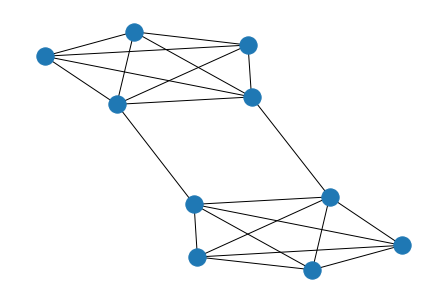

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(adj_matrix, parallel_edges=False, create_using=None)
nx.draw(G)
plt.draw()

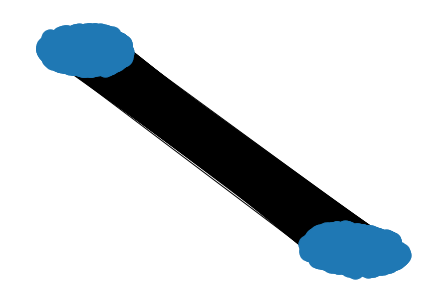

In [18]:
# n = 5000, k = 2, p = 0.8, q = 0.001
G = nx.from_numpy_matrix(adj_matrix_1, parallel_edges=False, create_using=None)
nx.draw(G)
plt.draw()

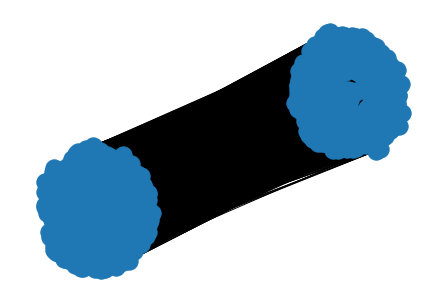

In [19]:
# n = 5000, k = 2, p = 0.8, q = 0.01
G = nx.from_numpy_matrix(adj_matrix_2, parallel_edges=False, create_using=None)
nx.draw(G)
plt.draw()

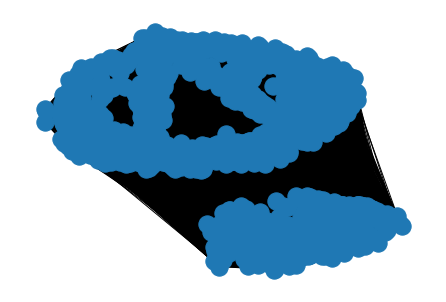

In [20]:
# n = 5000, k = 2, p = 0.8, q = 0.1
G = nx.from_numpy_matrix(adj_matrix_3, parallel_edges=False, create_using=None)
nx.draw(G)
plt.draw()

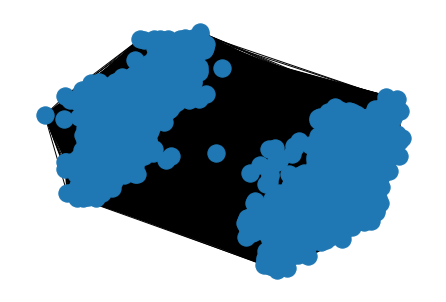

In [21]:
# n = 5000, k = 2, p = 0.8, q = 0.2
G = nx.from_numpy_matrix(adj_matrix_4, parallel_edges=False, create_using=None)
nx.draw(G)
plt.draw()

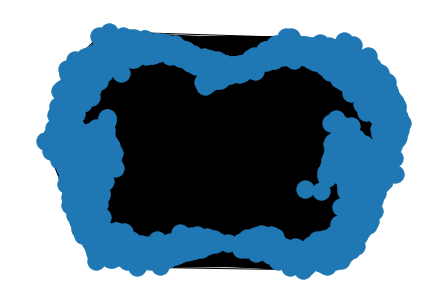

In [22]:
# n = 5000, k = 2, p = 0.8, q = 0.3
G = nx.from_numpy_matrix(adj_matrix_5, parallel_edges=False, create_using=None)
nx.draw(G)
plt.draw()

From the graphs drawn above, it can be clearly seen that the spectral algorithm works in practice (i.e.) When  the graphs with highly dense connected components and almost negligible edges between components are projected into a two dimensional space, the components are clearly separated from each other while as the number of edges between the connected components increase, the boundaries are not so clearly defined anymore and the clusters start mergeing together.